In [15]:
%matplotlib inline 
import numpy as np
import pandas as pd

import bt
import ffn 

import seaborn as sns
import matplotlib.pyplot as plt

import datetime


import pandas_datareader.data as wb

try:
#     sp500 = wb.DataReader('SPY',data_source='yahoo',start='1/1/2000',end='09/30/2019')
#     AMZN = wb.DataReader('AMZN',data_source='yahoo',start='1/1/2000',end='09/30/2019')
    TLT = wb.DataReader('TLT',data_source='yahoo',start='1/1/2000',end='09/30/2019')
#     sp500.info()
except():
    pass

##### https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

            Adj Close
Date                 
2002-07-30  44.622902
2002-07-31  45.175747
2002-08-01  45.433041
2002-08-02  45.898308
2002-08-05  46.100849


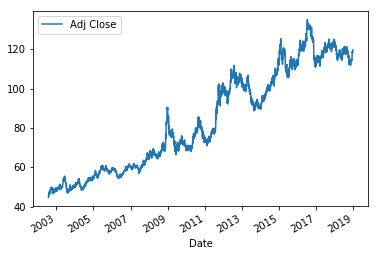

In [17]:
# def parser(x):
#     return datetime.datetime.strptime('190' +x, '%Y-%m')
series = pd.DataFrame(TLT['Adj Close'])
# summarize first few rows


# summarize first few rows
print(series.head())
# line plot
series.plot()
plt.show()



In [41]:
training_period = int(.70 * len(series))
testing_period = int(.30 * len(series))

# split data into train and test
X = series.values
train, test = X[0:-training_period], X[-training_period:]



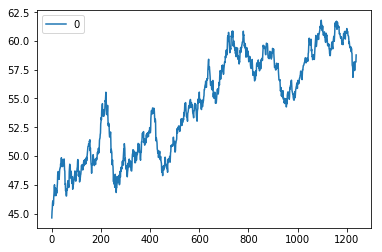

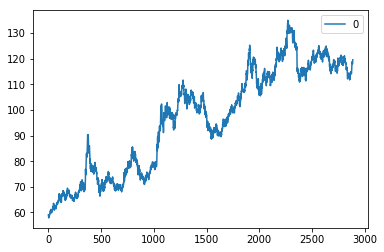

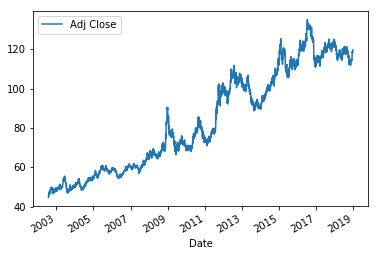

In [42]:
pd.DataFrame(train).plot()

pd.DataFrame((test)).plot()

series.plot()

RMSE: 0.864


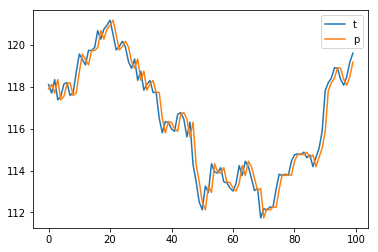

In [60]:
import math

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test[-100:])
plt.plot(predictions[-100:])
plt.legend("tp")
plt.show()

# LSTM Data Preparation
#### 1)Transform the time series into a supervised learning problem.
#### 2) Transform the time series data so that it is stationary.
#### 3) Transform the observations to have a specific scale.

###### The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

###### For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output. 

###### We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. 

###### The time series as it stands will be the output variables.We can then concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position.

###### We will replace these NaN values with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here,” as a month with zero sales on this dataset has not been observed.The code below defines a helper function to do this called timeseries_to_supervised(). 

###### It takes a NumPy array of the raw time series data and a lag or number of shifted series to create and use as inputs.

In [72]:
 # frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df



In [73]:
series = pd.DataFrame(TLT['Adj Close'])



In [74]:
# # transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(data=X, lag=1)

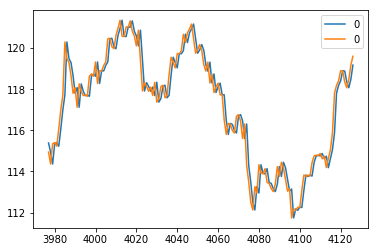

In [77]:
supervised[-150:].plot()

# Transform Time Series to Stationary

In [87]:

 
# invert differenced value
# def inverse_difference(history, yhat, interval=1):
# 	return yhat + history[-interval]
 
series = pd.DataFrame(TLT['Adj Close'])
# # transform to be stationary
differenced = series.diff()
print(differenced.head())
# invert transform

inverted = series.add(series.diff())
print(inverted.head())

            Adj Close
Date                 
2002-07-30        NaN
2002-07-31   0.552845
2002-08-01   0.257294
2002-08-02   0.465267
2002-08-05   0.202541
            Adj Close
Date                 
2002-07-30        NaN
2002-07-31  45.728592
2002-08-01  45.690334
2002-08-02  46.363575
2002-08-05  46.303391


# Transform Time Series to Scale

In [102]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt


series = pd.DataFrame(TLT['Adj Close'])
print(series.head())
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())

# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())


            Adj Close
Date                 
2002-07-30  44.622902
2002-07-31  45.175747
2002-08-01  45.433041
2002-08-02  45.898308
2002-08-05  46.100849
0   -1.000000
1   -0.987772
2   -0.982081
3   -0.971789
4   -0.967309
dtype: float64
0    44.622902
1    45.175747
2    45.433041
3    45.898308
4    46.100849
dtype: float64


# LSTM Model Development
The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

Samples: These are independent observations from the domain, typically rows of data.
Time steps: These are separate time steps of a given variable for a given observation.
Features: These are separate measures observed at the time of observation.

Given that the training dataset is defined as X inputs and y outputs, it must be reshaped into the Samples/TimeSteps/Features format, for example:

# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

# restart at this location.
